# Importacion librerias

In [97]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

# Datos

In [146]:

datos = pd.read_csv('D:/nuevo/universidad/Master/Proyecto_Integrador/Serie_Tiempo_Date_Normal.csv',  parse_dates=[0], infer_datetime_format= True)
# datos["UNIDADES"] = pd.to_numeric(datos["UNIDADES"])
datos

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_10960\988809827.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  datos = pd.read_csv('D:/nuevo/universidad/Master/Proyecto_Integrador/Serie_Tiempo_Date_Normal.csv',  parse_dates=[0], infer_datetime_format= True)


,Date,UNIDADES
0,2020-03-01,11
1,2020-04-01,16
2,2020-02-01,11
3,2020-11-01,3
4,2020-05-01,11
...,...,...
863,2022-09-25,8
864,2022-09-30,4
865,2022-09-29,7
866,2022-09-26,4


In [106]:
datos = pd.read_csv('D:/nuevo/universidad/Master/Proyecto_Integrador/bdSeriedetiempoSemanaAjustada.csv',  parse_dates=[2], infer_datetime_format= True)
datos["UNIDADES"] = pd.to_numeric(datos["UNIDADES"])
datos = datos[datos['PRENDA'] == 'BLUSAS']
datos = datos.drop(columns = ['SEMANACORRIDA','PRENDA'])
datos 


,SEMANA,ANO,UNIDADES
0,1,2020,38
8,2,2020,68
22,3,2020,73
28,4,2020,84
35,5,2020,119
...,...,...,...
1606,36,2022,37
1616,37,2022,52
1623,38,2022,55
1645,39,2022,48


In [149]:
# Determine the date
datos['date'] = pd.to_datetime(datos.assign(day=1, month=1, year= 1)['year', 'month', 'day']) + pd.to_timedelta(datos.week*7, unit = 'days')

# Plot
fig, ax = plt.subplots()
datos.plot(x='date', y='number_of_cases', marker='o', ax=ax)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
ax.xaxis.set_major_formatter(myFmt)

KeyError: ('year', 'month', 'day')

In [71]:
datos = datos.groupby(by = ['SEMANA', 'ANO']).sum()
datos = datos.sort_values(['SEMANA'],ascending = True) 
datos = datos.reset_index()
datos.head(25)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_10960\428557109.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datos = datos.groupby(by = ['SEMANA', 'ANO']).sum()


,SEMANA,ANO,UNIDADES,SEMANACORRIDA
0,1,2020,38,1
1,2,2020,68,2
2,2,2021,40,55
3,3,2020,73,3
4,3,2021,23,56
5,3,2022,37,109
6,4,2020,84,4
7,4,2021,39,57
8,4,2022,41,110
9,5,2020,119,5


In [115]:
# Preparación del dato
# ==============================================================================
datos['Date'] = pd.to_datetime(datos['Date'], format='%Y%m%d')
# datos = datos.set_index('SEMANA')
# datos = datos.drop(columns = ['SEMANA', 'ANO', 'PRENDA'])
datos = datos.rename(columns={'x': 'y'})
# datos = datos.asfreq('d')
datos = datos.sort_index()
datos

,Date,UNIDADES
0,2020-03-01,11
1,2020-04-01,16
2,2020-02-01,11
3,2020-11-01,3
4,2020-05-01,11
...,...,...
863,2022-09-25,8
864,2022-09-30,4
865,2022-09-29,7
866,2022-09-26,4


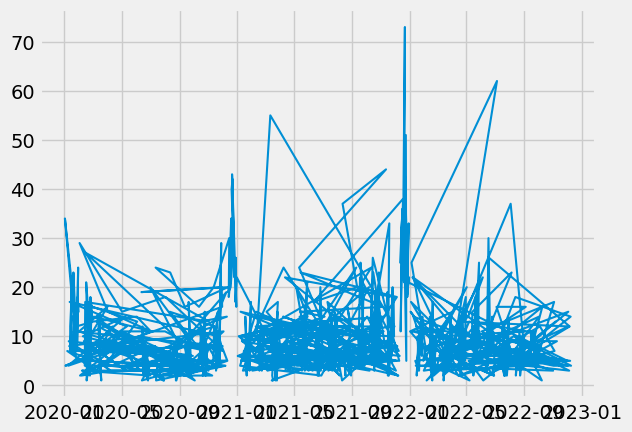

In [116]:
import plotly.express as px
plt.plot(  datos['Date'], datos['UNIDADES'])

In [117]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [118]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max()))
                    # freq  = datos.index.freq))

ValueError: Lengths must match to compare

## Separación Train-Test

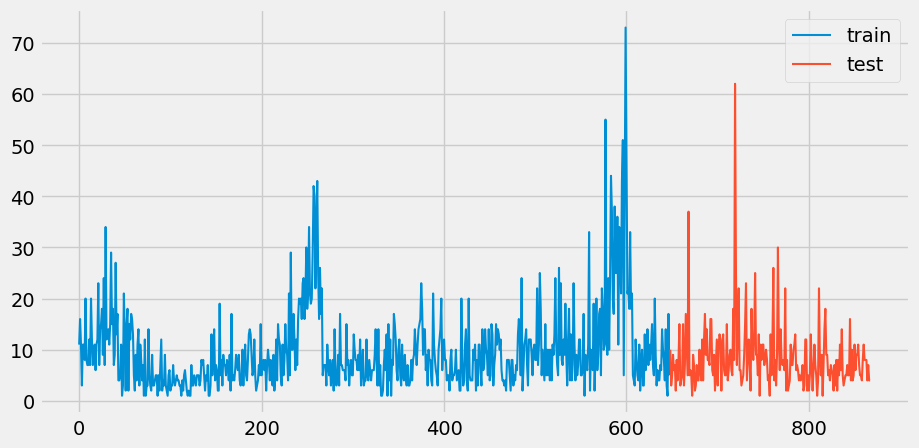

In [136]:
# Separación datos train-test
# ==============================================================================
steps = 220
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
# print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
fig, ax = plt.subplots(figsize=(10,5))
datos_train['UNIDADES'].plot(ax=ax, label='train')
datos_test['UNIDADES'].plot(ax=ax, label='test')
ax.legend();

## Crear y entrenar forecast

In [138]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=1234, max_depth= 100),
                lags = 2
             )

forecaster.fit(y=datos_train['UNIDADES'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=100, random_state=1234) 
Lags: [1 2] 
Transformer for y: None 
Transformer for exog: None 
Window size: 2 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 647] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 100, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-06 16:05:26 
Last fit date: 2022-12-06 16:05:26 
Skforecast version: 0.6.0 
Python version: 3.10.5 

In [139]:
# Predicciones
# ==============================================================================
steps = 220
predicciones = forecaster.predict(steps=steps)
predicciones.head(10)

648     7.327595
649     8.893333
650    19.561702
651     7.250000
652     7.838095
653     6.135829
654     6.411282
655     6.074774
656     6.074774
657     6.074774
Name: pred, dtype: float64

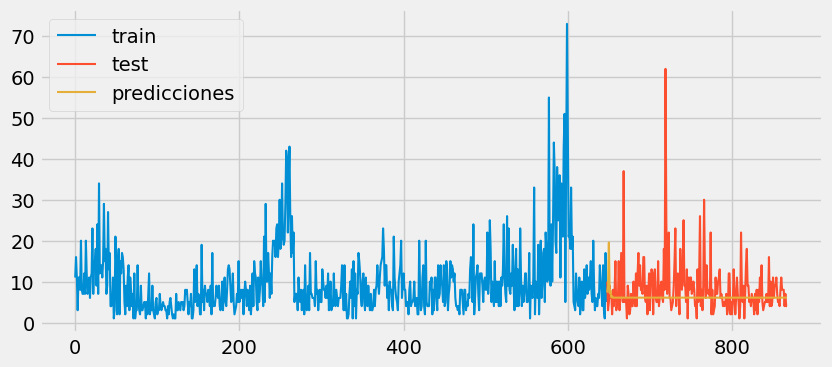

In [140]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNIDADES'].plot(ax=ax, label='train')
datos_test['UNIDADES'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['UNIDADES'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

In [27]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 20
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 100]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['UNIDADES'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12.


loop lags_grid:   0%|                                               | 0/2 [00:00<?, ?it/s]c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:589: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users

ValueError: `initial_train_size` must be greater than forecaster's window_size (100).

In [ ]:
##La mejor configuración del modelo se obtiene usando 10 Lags y una configuración Random Forest {'max_depth': 10, 'n_estimators': 500}

In [104]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",2257.018191,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",2262.323594,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",2285.193352,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",2285.867771,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",2289.658597,10,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",2292.507353,3,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",2293.677023,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",2296.842437,10,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",2297.883451,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",2298.896590,3,500


In [114]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=100)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 1
             )

forecaster.fit(y=datos_train['UNIDADES'])

c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


In [106]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:589: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


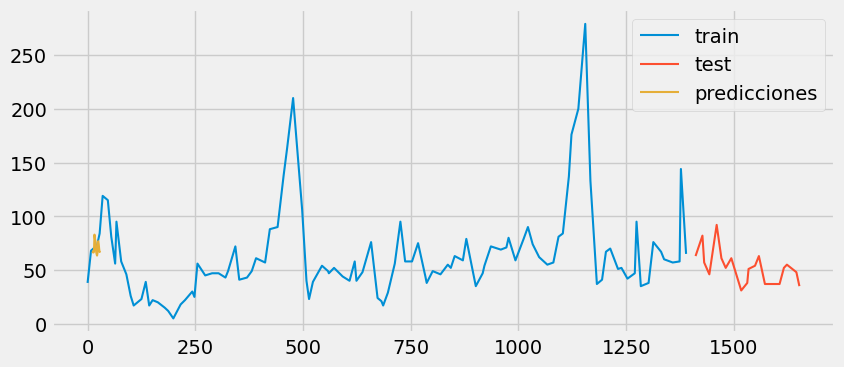

In [107]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNIDADES'].plot(ax=ax, label='train')
datos_test['UNIDADES'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [109]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['UNIDADES'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 625.8814813393539


In [111]:
# Backtesting
# ==============================================================================
steps = 20
n_backtesting = 20*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['UNIDADES'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 73
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 20

Data partition in fold: 0
    Training:   0 -- 871  (n=73)
    Validation: 879 -- 1139  (n=20)
Data partition in fold: 1
    Training:   0 -- 1139  (n=93)
    Validation: 1155 -- 1389  (n=20)
Data partition in fold: 2
    Training:   0 -- 1389  (n=113)
    Validation: 1411 -- 1652  (n=20)



c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:589: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.py:532: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\skforecast\utils\utils.

Error de backtest: 4430.987189441322


KeyError: '[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29] not in index'

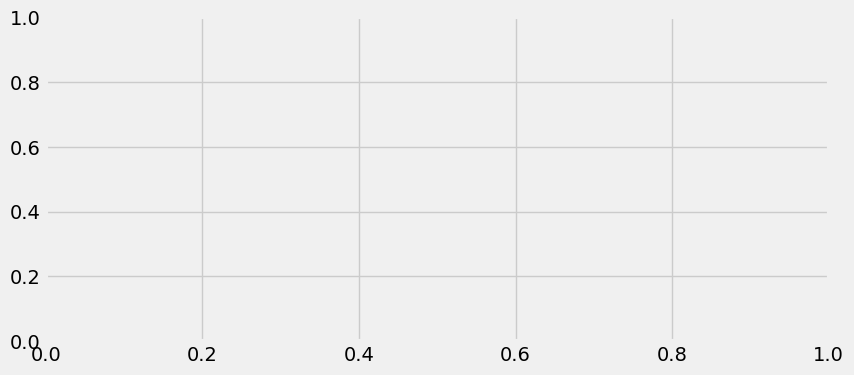

In [112]:
fig, ax = plt.subplots(figsize=(9, 4))
datos.loc[predicciones_backtest.index, 'UNIDADES'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

In [113]:
# Importancia predictores
# ==============================================================================
importancia = forecaster.get_feature_importance()
importancia

,feature,importance
0,lag_1,0.667590
1,lag_2,0.050307
2,lag_3,0.032486
3,lag_4,0.023375
4,lag_5,0.038325
5,lag_6,0.025204
6,lag_7,0.025660
7,lag_8,0.044429
8,lag_9,0.027397
9,lag_10,0.065226
